In [1]:
import numpy as np
import joblib

In [26]:
data = np.load("data/sst2.npz")

In [27]:
x_train = data["x_train"]
y_train = data["y_train"]
x_val = data["x_val"]
y_val = data["y_val"]

In [2]:
from sklearn.feature_extraction.text import TfidfVectorizer
import matplotlib.pyplot as plt

/bin/sh: lscpu: command not found


In [ ]:
vectorizer = TfidfVectorizer(max_features=4000)
vec_train = vectorizer.fit_transform(x_train)
vec_val = vectorizer.transform(x_val)

In [3]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
import sklearn.metrics as metrics

In [ ]:
# rfc = RandomForestClassifier()
# svc = SVC()
lr = LogisticRegression(max_iter=1000)

# rfc.fit(x, labels)
# svc.fit(x, labels)
lr = lr.fit(vec_train, y_train)

In [ ]:
y_pred = lr.predict(vec_val)
confusion_matrix = metrics.confusion_matrix(y_true=y_val, y_pred=y_pred,)
print(confusion_matrix)
print("f1 score: ", metrics.f1_score(y_true=y_val, y_pred=y_pred), "acc", metrics.accuracy_score(y_true=y_val, y_pred=y_pred))

In [ ]:
joblib.dump(lr, "models/tfidf_logistic.pkl")

In [ ]:
newlr = joblib.load("models/tfidf_logistic.pkl")
newvec = joblib.load("models/tfidf_vec.pkl")
vec_val = newvec.transform(x_val)
y_pred = lr.predict(vec_val)
print("f1 score: ", metrics.f1_score(y_true=y_val, y_pred=y_pred), "acc", metrics.accuracy_score(y_true=y_val, y_pred=y_pred))

In [ ]:
newvec = joblib.load("models/tfidf_vec.pkl")
tmp = np.array(['hello it is me'])
result = newvec.transform(tmp)
print(result)

In [ ]:
# joblib.dump(vectorizer, "models/tfidf_vec.pkl")
print(x_train)

In [40]:
from transformers import BertTokenizer, BertModel
import torch
import tqdm

/Users/mccartney/.local/lib/python3.9/site-packages/tqdm-4.65.0-py3.9.egg/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [ ]:
bs = 128
tmp_train = [x for x in x_train]
max_len = len(tmp_train)
new_x_train = []

import math
for i in range(int(math.ceil(max_len/bs))):
    end = -1 if (i+1)*bs>max_len else (i+1)*bs
    new_x_train.append(tmp_train[i*bs:end])

print(len(new_x_train))
print(len(new_x_train[0]))

In [41]:
with torch.no_grad():
    x_bert_train = []
    tokenizer = BertTokenizer.from_pretrained('/Users/mccartney/Downloads/bert-base-uncased')
    model = BertModel.from_pretrained("/Users/mccartney/Downloads/bert-base-uncased")
    # for i, xi in enumerate(new_x_train):
    #     encoded_input = tokenizer(xi, return_tensors='pt', padding=True)
    #     output = model(**encoded_input)
    #     x_bert_train.append(output.last_hidden_state[:, 0, :])

Some weights of the model checkpoint at /Users/mccartney/Downloads/bert-base-uncased were not used when initializing BertModel: ['cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.weight', 'cls.predictions.decoder.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [ ]:
encoded_input = tokenizer(x_train[-1], return_tensors='pt')
output = model(**encoded_input)
tmp_out = output.last_hidden_state[0, 0, :]
print(tmp_out.size())

In [ ]:
x_bert_train = torch.cat(x_bert_train, dim=0)
print(x_bert_train.size())

In [ ]:
x_bert_train = x_bert_train.numpy()

In [ ]:
tmp_out = tmp_out.reshape(1, -1)
print(x_bert_train.shape)
print(tmp_out.shape)

newx = [x_bert_train, tmp_out]
newx = np.concatenate(newx)
print(newx.shape)

In [ ]:
bert_lr = LogisticRegression(max_iter=1000)
bert_lr = bert_lr.fit(newx, y_train)

In [ ]:
joblib.dump(bert_lr, "./bert_base_uncased_logistic.pkl")

In [42]:
with torch.no_grad():
    x_bert_val = []
    for xi in tqdm.tqdm(x_val):
        encoded_input = tokenizer(xi, return_tensors='pt')
        encoded_input = {k:v for k, v in encoded_input.items()}
        output = model(**encoded_input)
        x_bert_val.append(output[0][:, 0, :])

x_bert_val = torch.cat(x_bert_val, dim=0)
x_bert_val = x_bert_val.numpy()

  0%|          | 0/872 [00:00<?, ?it/s]

Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.


100%|██████████| 872/872 [01:08<00:00, 12.79it/s]


In [ ]:
y_pred = bert_lr.predict(x_bert_val)
# print(confusion_matrix)
print("f1 score: ", metrics.f1_score(y_true=y_val, y_pred=y_pred), "acc", metrics.accuracy_score(y_true=y_val, y_pred=y_pred))

In [ ]:
print(type(y_pred))

In [ ]:
np.save('data/bert_train_vec.npy', newx)
np.save('data/bert_val_vec.npy', x_bert_val)

In [ ]:
x_bert_train = np.load('data/bert_train_vec.npy')
x_bert_val = np.load('data/bert_val_vec.npy')

In [ ]:
vectorizer = joblib.load("models/tfidf_vec.pkl")
vec_val = vectorizer.transform(x_val)
vec_train = vectorizer.transform(x_train)

In [ ]:
from sklearn.neighbors import KNeighborsClassifier 

result = {}
for n in range(10,40):
    neigh = KNeighborsClassifier(n_neighbors=n)  
    neigh.fit(vec_train, y_train)  
    y_pred = neigh.predict(vec_val)
    acc = metrics.accuracy_score(y_true=y_val, y_pred=y_pred)

    result[n]=acc

for key in result:
    print(key, result[key])


In [ ]:
np.save('knn_tfidf.npy', result)

In [ ]:
print(max(result.items(),key=lambda x:x[1]))

In [ ]:
neigh = KNeighborsClassifier(n_neighbors=15)  
neigh.fit(vec_train, y_train) 
joblib.dump(neigh, 'models/tfidf_knn.pkl')

In [ ]:
svm = SVC(max_iter=1000)
svm.fit(x_bert_train, y_train)
y_pred = svm.predict(x_bert_val)
print(confusion_matrix)
print("f1 score: ", metrics.f1_score(y_true=y_val, y_pred=y_pred), "acc", metrics.accuracy_score(y_true=y_val, y_pred=y_pred))

In [ ]:
joblib.dump(svm, "./bert_base_uncased_svm.pkl")

In [ ]:
from gensim.models import doc2vec

In [ ]:
doc_train = [doc2vec.TaggedDocument(doc, [i]) for i, doc in enumerate(x_train)]

In [ ]:
model = doc2vec.Doc2Vec(doc_train, vector_size=512, epochs=10)

In [ ]:
joblib.dump(model, "./doc2vec.pkl")

In [ ]:
vec_doc_val =  [model.infer_vector([doc])[None] for doc in x_val]
vec_doc_val = np.concatenate(vec_doc_val, axis=0)

In [ ]:
vec_doc_train = [model.infer_vector([doc])[None] for doc in x_train]
vec_doc_train = np.concatenate(vec_doc_train, axis=0)

In [ ]:
doc_lr = LogisticRegression()
doc_lr = doc_lr.fit(vec_doc_train, y_train)

In [ ]:
y_pred = doc_lr.predict(vec_doc_val)
print(confusion_matrix)
print("f1 score: ", metrics.f1_score(y_true=y_val, y_pred=y_pred), "acc", metrics.accuracy_score(y_true=y_val, y_pred=y_pred))

In [ ]:
vectorizer = joblib.load("models/tfidf_vec.pkl")
a = vectorizer.transform(["hello you are good"])

lr = joblib.load("models/tfidf_logistic.pkl")
pred = lr.predict(a)

print(pred)

In [23]:
data = np.load('data/knn_tfidf.npy', allow_pickle=True).item()
x = np.array(list(data.keys()))
y = np.array(list(data.values()))
max_index = np.argmax(y)
print(x)

[10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33
 34 35 36 37 38 39]


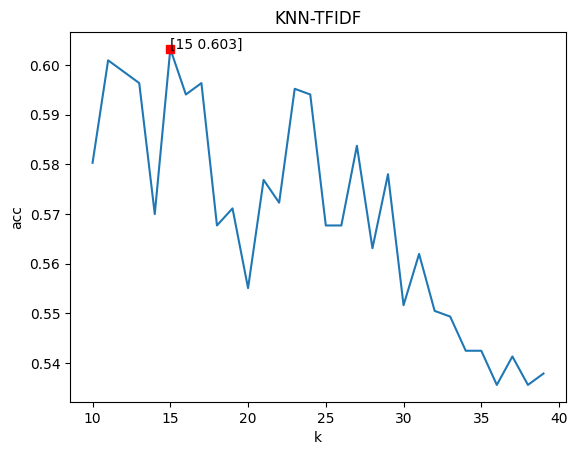

In [25]:
plt.plot(x,y)
plt.plot(x[max_index],y[max_index],'rs')
show_max='['+str(x[max_index])+' '+str(round(y[max_index],3))+']'
plt.annotate(show_max,xytext=(x[max_index],y[max_index]),xy=(x[max_index],y[max_index]))
plt.title('KNN-TFIDF')
plt.xlabel('k')
plt.ylabel('acc')
plt.show()

In [30]:
vectorizer = joblib.load('models/tfidf_vec.pkl')
vec_val = vectorizer.transform(x_val)
print(vec_val.shape)
print(y_val.shape)

(872, 4000)
(872,)


In [43]:
from sklearn.manifold import TSNE 
 
tsne = TSNE(n_components=2, init="random") 
X_tsne = tsne.fit_transform(x_bert_val) 

In [44]:
idx = np.where(y_val==1)[0]
pos_point = X_tsne[idx]
idx = np.where(y_val==0)[0]
neg_point = X_tsne[idx]

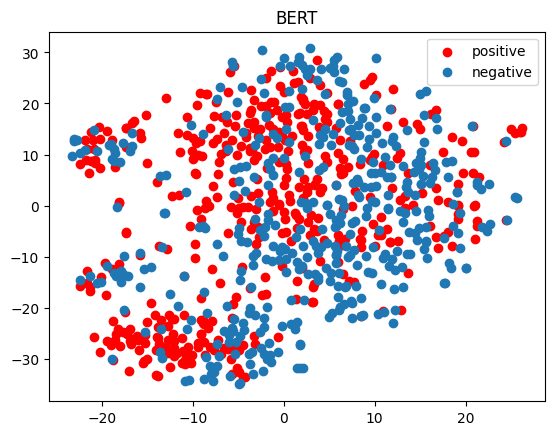

In [45]:
plt.scatter(pos_point[:,0], pos_point[:,1], c='r', label='positive')
plt.scatter(neg_point[:,0], neg_point[:,1], label='negative')
plt.title('BERT')
plt.legend()
plt.show()